# Project description
Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.
You have access to behavior data about subscribers who have already switched to the new plans (from the project for the Statistical Data Analysis course). For this classification task, you need to develop a model that will pick the right plan. Since you’ve already performed the data preprocessing step, you can move straight to creating the model.
Develop a model with the highest possible accuracy. In this project, the threshold for accuracy is 0.75. Check the accuracy using the test dataset.

# 1. Open and look through the data file. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('/datasets/users_behavior.csv')

display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [2]:
#General information about dataset.

print(df.shape)
print()
print('The dataset has {0}'.format(df.shape[0]), 'rows')
print()
print('The dataset has {0}'.format(df.shape[1]), 'columns')
print()
print('The dataset has {0}'.format(df.duplicated().sum()), 'duplicates')
print()
print()
print('NaN in the whole dataset are:')
print(df.isna().sum())

(3214, 5)

The dataset has 3214 rows

The dataset has 5 columns

The dataset has 0 duplicates


NaN in the whole dataset are:
calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


In [3]:
print(df.describe())
print()
print('The number of non-ultra customers is:', df.is_ultra.loc[df.is_ultra == 0].count())
print()
print('The number of ultra customers is:', df.is_ultra.loc[df.is_ultra == 1].count())
print()
print('The percentage of non-ultra customers is:', (len(df.is_ultra.loc[df.is_ultra == 0])/len(df.is_ultra)*100),'%')
print()
print('The percentage of ultra customers is:', (len(df.is_ultra.loc[df.is_ultra == 1])/len(df.is_ultra)*100),'%')

             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000

The number of non-ultra customers is: 2229

The number of ultra customers is: 985

The percentage of non-ultra customers is: 69.35283136278781 %

The percentage of ultra customers is: 30.647168637212197 %


In [4]:
#Creating a target variable.
y_true = df.is_ultra.values

#Printing how the variable itself + len of the variable.
print(y_true)
print()
print(len(y_true)) #Should return the len of the starting dataframe.

[0 0 0 ... 0 0 1]

3214


# Brief summarize. Task 1.
1. Open and look through the data file. 

I opened the dataset reading the .csv file. We had an initial dataset of 3214 rows and 5 columns.
The dataset has no duplicates and no NaN values.

I checked the number of non-ultra (0) customers and ultra (1) customers.
We have a percentage of non-ultra customers of:   69.35283136278781 %
We have a percentage of ultra customers of:       30.64716863721219 %

# 2. Split the source data into a training set, a validation set and a test set.

In [5]:
# Splitting the data into train and test.
df_train, df_test = train_test_split(df, stratify=y_true, test_size=0.2, random_state=8)
#Splitting the training dataset into train validation and cross validation.
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=8)

In [6]:
print('Number of records in training dataset:', df_train.shape[0])
print('Number of records in cross validation dataset:', df_valid.shape[0])
print('Number of records in the test dataset:', df_test.shape[0])
print('')
print('Train and Cross validation dataset are going to be used to build the model itself.')
print('Test is going to check the accuracy of our model output.')

Number of records in training dataset: 2056
Number of records in cross validation dataset: 515
Number of records in the test dataset: 643

Train and Cross validation dataset are going to be used to build the model itself.
Test is going to check the accuracy of our model output.


In [7]:
print('To make sure that our testing is going to have a positive result,')
print('We can save the column in a variable to be able, to compare that to the model results obtained.')

checking_values = df_test.is_ultra #This is going to become the array to check the accuracy of our model.

To make sure that our testing is going to have a positive result,
We can save the column in a variable to be able, to compare that to the model results obtained.


In [8]:
#Creating features and targets for our model.
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

In [9]:
#Let's take a look to the distribution of is_ultra column in the three dataset.
#The importance of this step, lies in the fact, that we should make sure, that everyone of our datasets (train,test,cv) 
#has at least a 25% of ultra customers in it. Our initial rate of percentage is 70/30 (whole dataset)
#Otherwise the prediction of our model are going to be distorted.
#To change this split is just necessary changing random_state parameter in train_test_split function.

train_is_ultra_distribution = df_train['is_ultra'].value_counts(normalize=True)
cv_is_ultra_distribution = df_valid['is_ultra'].value_counts(normalize=True)
test_is_ultra_distribution =  checking_values.value_counts(normalize=True)

print('Train dataset:')
print(train_is_ultra_distribution)
print()
print('Validation dataset:')
print(cv_is_ultra_distribution)
print()
print('Testing array:')
print(test_is_ultra_distribution)
print()
print('Our train, test and cv datasets, correspond almost perfectly to the whole dataset.')

Train dataset:
0    0.695039
1    0.304961
Name: is_ultra, dtype: float64

Validation dataset:
0    0.687379
1    0.312621
Name: is_ultra, dtype: float64

Testing array:
0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

Our train, test and cv datasets, correspond almost perfectly to the whole dataset.


# Brief summarize. Task 2.

2. Split the source data into a training set, a validation set and a test set.
Through train_test_split I splitted two times the dataset.

The First time I splitted the entire dataframe: obtaining 80% of df_train and 20% of df_test. 
(percentages on the starting dataset)

The Second time I splitted the train dataframe: obtaining 80% of df_train and 20% of df_valid. 
(percentages on the training dataset)

The result of the split allow us to have 3 dataset: one for training, one for validation and another to test our model.
The number of records in training dataset is 2056.
The number of records in cross validation dataset is 515.
The number of records in the test dataset is 643.

I saved in checking_values variable the value of df_test.is_ultra, this allow us to compare the predictions with the real values we have in test dataset.

After that I created variables for each of the 3 dataset containing features and target of our program and checked their distribution. I tried in doing this, many random_state values (finding in 8 the better one).

# 3. Investigate the quality of different models by changing hyperparameters. 

In [10]:
print('Since we need a classification model, going to implement a Classifier model.')
print()
print('Our choice is going to be one from DecisionTreeClassifier / RandomForestClassifier / LogisticRegression')

Since we need a classification model, going to implement a Classifier model.

Our choice is going to be one from DecisionTreeClassifier / RandomForestClassifier / LogisticRegression


In [50]:
#Finding accuracy score for DecisionTreeClassifier
result = []

for depth in range(1, 10):
        model = DecisionTreeClassifier(random_state = 8, max_depth=depth)
        # < create a model, specify max_depth=depth >
        model.fit(features_train, target_train) # < train the model >
        predictions_valid = model.predict(features_valid) # < find the predictions using validation set >        
        print("max_depth =", depth, ": ", end='')
        acc = accuracy_score(target_valid, predictions_valid)
        print(acc)
        result.append(acc)
print()
print('The best possible option here is max_depth = 4. We found our tree depth.')
print('The best possible accuracy obtained within this hyperparameter is :', max(result))


#Depth of 3,4 and 5 gives us the best possible result (78/79%). 
#This is a good result but not that much, going to try to adopt another model.

max_depth = 1 : 0.7359223300970874
max_depth = 2 : 0.7708737864077669
max_depth = 3 : 0.7844660194174757
max_depth = 4 : 0.7902912621359224
max_depth = 5 : 0.7864077669902912
max_depth = 6 : 0.7728155339805826
max_depth = 7 : 0.7825242718446602
max_depth = 8 : 0.7766990291262136
max_depth = 9 : 0.7766990291262136

The best possible option here is max_depth = 4. We found our tree depth.
The best possible accuracy obtained within this loop is : 0.7902912621359224


In [51]:
model = DecisionTreeClassifier(random_state = 8, max_depth=4)
result=[]

for leafs in range(2, 10):
        model = DecisionTreeClassifier(random_state = 8, max_depth=4, max_leaf_nodes=leafs)
        # < create a model, specify max_depth=depth >
        model.fit(features_train, target_train) # < train the model >
        predictions_valid = model.predict(features_valid) # < find the predictions using validation set >

        print("max_leaf_nodes =", leafs, ": ", end='')
        acc=accuracy_score(target_valid, predictions_valid)
        print(acc)
        result.append(acc)
print()
print('The best possible option here is max_leaf_nodes = 5. We found the number of max leaf in a node.')
print('The best possible accuracy obtained tuning this hyperparameter is :', max(result))

max_leaf_nodes = 2 : 0.7359223300970874
max_leaf_nodes = 3 : 0.7708737864077669
max_leaf_nodes = 4 : 0.7844660194174757
max_leaf_nodes = 5 : 0.7922330097087379
max_leaf_nodes = 6 : 0.7922330097087379
max_leaf_nodes = 7 : 0.7922330097087379
max_leaf_nodes = 8 : 0.7922330097087379
max_leaf_nodes = 9 : 0.7922330097087379

The best possible option here is max_leaf_nodes = 5. We found the number of max leaf in a node.
The best possible accuracy obtained within this loop is : 0.7922330097087379


In [54]:
model = DecisionTreeClassifier(random_state = 8, max_depth=4, max_leaf_nodes=5)
result=[]

for min_samples in range(1, 100,10):
        model = DecisionTreeClassifier(random_state = 8, max_depth=4, max_leaf_nodes=5, min_samples_leaf=min_samples)
        # < create a model, specify max_depth=depth >
        model.fit(features_train, target_train) # < train the model >
        predictions_valid = model.predict(features_valid) # < find the predictions using validation set >

        print("min_samples_leaf =", min_samples, ": ", end='')
        acc=accuracy_score(target_valid, predictions_valid)
        print(acc)
        result.append(acc)
print()
print('The best possible option here is min_samples_leaf = 21.')
print('The best possible accuracy obtained tuning this hyperparameter is :', max(result))

min_samples_leaf = 1 : 0.7922330097087379
min_samples_leaf = 11 : 0.7922330097087379
min_samples_leaf = 21 : 0.7922330097087379
min_samples_leaf = 31 : 0.7844660194174757
min_samples_leaf = 41 : 0.7825242718446602
min_samples_leaf = 51 : 0.7766990291262136
min_samples_leaf = 61 : 0.7766990291262136
min_samples_leaf = 71 : 0.7766990291262136
min_samples_leaf = 81 : 0.7805825242718447
min_samples_leaf = 91 : 0.7708737864077669

The best possible option here is min_samples_leaf = 21.
The best possible accuracy obtained within this loop is : 0.7922330097087379


In [55]:
#Calculating rmse of DecisionTreeClassifier model for max_depth=4
model = DecisionTreeClassifier(random_state = 8, max_depth=4, max_leaf_nodes=5, min_samples_leaf=21)
model.fit(features_train, target_train) # < train the model >
predictions_valid = model.predict(features_valid) # < find the predictions using validation set >

acc = accuracy_score(target_valid, predictions_valid)
print('Accuracy score of DecisionTreeClassifier model is:', acc) #the lowest, the best.
print()
rmse_tree = mean_squared_error(target_valid, predictions_valid)**0.5
print('Rmse for DecisionTreeClassifier (with max_depth=4) is:', rmse_tree) #the lowest, the best.
print()
print()
print()
print('The best possible DecisionTreeClassifier model is the following:')
print()
print(model)

Accuracy score of DecisionTreeClassifier model is: 0.7922330097087379

Rmse for DecisionTreeClassifier (with max_depth=4) is: 0.45581464466519955



The best possible DecisionTreeClassifier model is the following:

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=21, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=8, splitter='best')


In [59]:
#Finding Rmse for RandomForestClassifier, criterion=gini
result=[]

for estim in range(10, 51, 5):
        model = RandomForestClassifier(n_estimators=estim, max_depth=10, random_state=8)
        model.fit(features_train, target_train) # < train the model >
        predictions_valid = model.predict(features_valid) 
        # < write code here >
        
        acc = accuracy_score(target_valid, predictions_valid)
        rmse = mean_squared_error(target_valid, predictions_valid)**0.5
        print("n_estimators =", estim, "Rmse:", rmse)
        print('n_estimators =', estim, 'Accuracy:', acc)
        result.append(acc)
        print()
        
print('The best possible accuracy obtained tuning this hyperparameter is :', max(result))

n_estimators = 10 Rmse: 0.4294950749630032
n_estimators = 10 Accuracy: 0.8155339805825242

n_estimators = 15 Rmse: 0.4384438501207855
n_estimators = 15 Accuracy: 0.8077669902912621

n_estimators = 20 Rmse: 0.44065264923923175
n_estimators = 20 Accuracy: 0.8058252427184466

n_estimators = 25 Rmse: 0.43622386699482907
n_estimators = 25 Accuracy: 0.8097087378640777

n_estimators = 30 Rmse: 0.44065264923923175
n_estimators = 30 Accuracy: 0.8058252427184466

n_estimators = 35 Rmse: 0.44065264923923175
n_estimators = 35 Accuracy: 0.8058252427184466

n_estimators = 40 Rmse: 0.44065264923923175
n_estimators = 40 Accuracy: 0.8058252427184466

n_estimators = 45 Rmse: 0.44065264923923175
n_estimators = 45 Accuracy: 0.8058252427184466

n_estimators = 50 Rmse: 0.4472135954999579
n_estimators = 50 Accuracy: 0.8

The best possible accuracy obtained tuning this hyperparameter is : 0.8155339805825242


In [61]:
#Finding rmse for RandomForestClassifier, criterion=entropy
result=[]

for estim in range(10, 51, 5):
        model = RandomForestClassifier(n_estimators=estim, criterion='entropy',max_depth=10, random_state=8)
        model.fit(features_train, target_train) # < train the model >
        predictions_valid = model.predict(features_valid) 
        # < write code here >

        acc = accuracy_score(target_valid, predictions_valid)
        rmse = mean_squared_error(target_valid, predictions_valid)**0.5
        print("n_estimators =", estim, "Rmse:", rmse)
        print('n_estimators =', estim, 'Accuracy:', acc)
        result.append(acc)
        print()

print('The best possible accuracy obtained tuning this hyperparameter is :', max(result))
print('I will esclude entropy criterion in favor of Gini.')

n_estimators = 10 Rmse: 0.4384438501207855
n_estimators = 10 Accuracy: 0.8077669902912621

n_estimators = 15 Rmse: 0.45153460016440716
n_estimators = 15 Accuracy: 0.7961165048543689

n_estimators = 20 Rmse: 0.45153460016440716
n_estimators = 20 Accuracy: 0.7961165048543689

n_estimators = 25 Rmse: 0.442850431697169
n_estimators = 25 Accuracy: 0.8038834951456311

n_estimators = 30 Rmse: 0.4384438501207855
n_estimators = 30 Accuracy: 0.8077669902912621

n_estimators = 35 Rmse: 0.44503736070939537
n_estimators = 35 Accuracy: 0.8019417475728156

n_estimators = 40 Rmse: 0.44503736070939537
n_estimators = 40 Accuracy: 0.8019417475728156

n_estimators = 45 Rmse: 0.44065264923923175
n_estimators = 45 Accuracy: 0.8058252427184466

n_estimators = 50 Rmse: 0.442850431697169
n_estimators = 50 Accuracy: 0.8038834951456311

The best possible accuracy obtained tuning this hyperparameter is : 0.8077669902912621
I will esclude entropy criterion in favor of Gini.


In [17]:
model = RandomForestClassifier(n_estimators=10,max_depth=10, random_state=8)
model.fit(features_train, target_train) # < train the model >
predictions_valid = model.predict(features_valid) 

acc_forest = accuracy_score(target_valid, predictions_valid)
rmse_forest = mean_squared_error(target_valid, predictions_valid)**0.5
print('Rmse for RandomForestClassifier (criterion=gini and n_estimators=10) is:', rmse_forest) #the lowest, the best.
print('Accuracy score for RandomForestClassifier (n_estimators=10) is:', acc_forest)

Rmse for RandomForestClassifier (criterion=gini and n_estimators=10) is: 0.4294950749630032
Accuracy score for RandomForestClassifier (n_estimators=10) is: 0.8155339805825242


In [18]:
#Finding Rmse values for LogisticRegression

model = LogisticRegression(random_state=8, solver='liblinear', max_iter=100)
model.fit(features_train, target_train) # < train the model >
predictions_valid = model.predict(features_valid) 

acc_logistic = accuracy_score(target_valid, predictions_valid)
rmse_logistic = mean_squared_error(target_valid, predictions_valid)**0.5
print("Logistic regression rmse:", rmse_logistic) 
print('Logistic regression accuracy:', acc_logistic)

Logistic regression rmse: 0.5287831790870781
Logistic regression accuracy: 0.7203883495145631


In [62]:
result=[]
for scale in range(1, 10):
        model = LogisticRegression(random_state=8, solver='liblinear', max_iter=100, intercept_scaling=scale)
        model.fit(features_train, target_train) # < train the model >
        predictions_valid = model.predict(features_valid) 
        # < write code here >
        acc = accuracy_score(target_valid, predictions_valid)
        rmse = mean_squared_error(target_valid, predictions_valid)**0.5
        print("Intercept scaling =", scale, "Rmse:", rmse)
        print('Intercept scaling=', scale, 'Accuracy', acc)
        result.append(acc)
        print()
print()
print('Optimal scale value equal to 6.')
print('The best possible accuracy obtained tuning this hyperparameter is :', max(result))

Intercept scaling = 1 Rmse: 0.5287831790870781
Intercept scaling= 1 Accuracy 0.7203883495145631

Intercept scaling = 2 Rmse: 0.5269439276741135
Intercept scaling= 2 Accuracy 0.7223300970873786

Intercept scaling = 3 Rmse: 0.5269439276741135
Intercept scaling= 3 Accuracy 0.7223300970873786

Intercept scaling = 4 Rmse: 0.5269439276741135
Intercept scaling= 4 Accuracy 0.7223300970873786

Intercept scaling = 5 Rmse: 0.5269439276741135
Intercept scaling= 5 Accuracy 0.7223300970873786

Intercept scaling = 6 Rmse: 0.5250982339903705
Intercept scaling= 6 Accuracy 0.7242718446601941

Intercept scaling = 7 Rmse: 0.5269439276741135
Intercept scaling= 7 Accuracy 0.7223300970873786

Intercept scaling = 8 Rmse: 0.5269439276741135
Intercept scaling= 8 Accuracy 0.7223300970873786

Intercept scaling = 9 Rmse: 0.5250982339903705
Intercept scaling= 9 Accuracy 0.7242718446601941


Optimal scale value equal to 6.
The best possible accuracy obtained tuning this hyperparameter is : 0.7242718446601941


In [63]:
model = LogisticRegression(random_state=8, solver='liblinear', max_iter=100, intercept_scaling=6, penalty='l1')
model.fit(features_train, target_train) # < train the model >
predictions_valid = model.predict(features_valid) 
        # < write code here >

acc_logistic = accuracy_score(target_valid, predictions_valid)
rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print('Accuracy score is:', acc_logistic)
print("RMSE value is :", rmse) 
print()
print()
print('Optimal LogisticRegression model is:')
print()
print(model)
print()
print('Going to esclude LogisticRegression model since its values are much lower then other kind of models.')

Accuracy score is: 0.7262135922330097
RMSE value is : 0.5232460298626167


Optimal LogisticRegression model is:

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=6, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=8, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Going to esclude LogisticRegression model since its values are much lower then other kind of models.


In [21]:
# I choose RandomForestClassifier as training model for the dataset. Now I am going to test all the values for
# RandomForestClassifier, in order to find the best model possible.

#Creating a parameters dictionary for possible hyperparameters values.
parameters = { 'random_state' : (8,10),
              'n_estimators': (5,10),
              'criterion': ('gini','entropy'),
              'max_depth': (10,5),
              'max_features': ('auto','sqrt'),
              } 

#Creating a grid model.
RF_grid = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=5) #THIS WILL TAKE REALLY LONG TIME TO EXECUTE.
RF_grid_model = RF_grid.fit(features_train, target_train)

In [22]:
print(RF_grid_model.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=8, verbose=0,
                       warm_start=False)


In [23]:
#Grid Model accuracy score.
print('Accuracy score:',RF_grid_model.best_score_)

Accuracy score: 0.8044747081712063


In [24]:
predictions_valid = RF_grid_model.predict(features_valid) 
        # < write code here >

rmse = mean_squared_error(target_valid, predictions_valid)**0.5
print("RMSE value is :", rmse)

RMSE value is : 0.4294950749630032


In [25]:
model = RF_grid_model
print(model)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

# Brief summarize. Task 3.
3. Investigate the quality of different models by changing hyperparameters. Briefly describe the findings of the study.

First of all I understood we needed classification models and not regression ones. Cause our target is a binary classification. If we have to 'label' our target classification models perform tasks better.

I started from a DecisionTreeClassifier, with a really simple loop I watched trough the depth of our tree, finding in 4 its optimal depth, I did the same for max_leafs_nodes parameter finding in 5 our optimal value. Furthermore, checked for the min_samples_leaf parameter, I decided to choose 21. (21 in this case, is a better value then 1 or 11 cause even if the accuracy score is the same, a low value in this parameter could lead us to overfit our model.)

Having this DecisionTreeClassifier model I obtained an accuracy of 0.7922330097087379 and an Rmse of 0.45581464466519955.

After that I created a RandomForestClassifier model, I checked the hyperparameters as before finding in Gini the best criterion, in 10 the perfect number of estimators.

Having this RandomForestClassifier model I obtained an accuracy of 0.8155339805825242 and an Rmse of 0.4294950749630032.

I created as well a LogisticRegression model

Since the accuracy of this model was 0.7203883495145631 and the Rmse was 0.5287831790870781, I decided to don't go further in tuning the hyperparameters.

Decided that Random Forest Classifier was the best model to take in consideration, I created a dictionary to check many possible values at time for my model. Resulted in a final RandomForest model named 'RF_grid_model'.

This model has an accuracy of 0.8044747081712063 and an Rmse value of 0.4294950749630032.

# 4. Check the quality of the model using the test set.

In [69]:
#Testing the best model on the test dataset.
model = RandomForestClassifier(n_estimators=10,max_depth=10, random_state=8)
model.fit(features_train, target_train) # < train the model >
predictions_test = model.predict(features_test)

In [70]:
print(f'Test: {model.score(features_test, target_test):.3f}')
print(f'Train: {model.score(features_train, target_train):.3f}')
print()
print('This model, obtained an 81% accuracy on test dataset, while 87% on the trained dataset.')

Test: 0.810
Train: 0.879

This model, obtained an 81% accuracy on test dataset, while 87% on the trained dataset.


# Brief summarize. Task 4.
4. Check the quality of the model using the test set.

While the accuracy of the model on the validation dataset is 80,44%. The accuracy obtained on the test dataset is 81,0% and the accuracy on the training dataset is 87,9%. This is normal cause obviously the model is more accurate on the training dataset, since it was trained on it.

# 5. Additional task: sanity check the model. 

In [28]:
#SANITY CHECK.
#Predictions array.
print(predictions_test)
print(len(predictions_test))

[0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 1 0
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1
 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 

In [29]:
#Checking values array.
print(checking_values.values)
print(len(checking_values))

[1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0
 0 1 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0
 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1
 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1
 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0
 0 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 0 

In [30]:
score = accuracy_score(target_test, predictions_test)
print(score)

0.8102643856920684


In [31]:
#Creating a confusion matrice.
cm = confusion_matrix(target_test, predictions_test)
print(cm)

[[414  32]
 [ 90 107]]


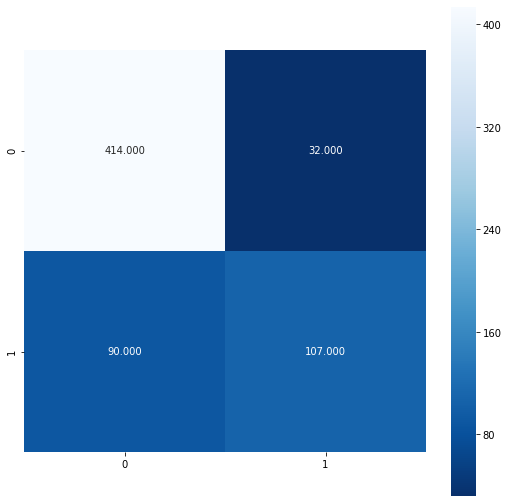

In [32]:
#Seaborn heatmap of our confusion matrice.
#Our highest values should lie on the diagonal if our model perform well the task.
#This heatmap works better with bigger confusion matrices
#(When you have to classify something divided in many categories.)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt='.3f',square=True, cmap='Blues_r')
plt.ylabel='Actual label'
plt.xlabel='Predicted label'

In [33]:
#Extracting TruePositive, FalsePositive, FalseNegative and TrueNegative from our confusion matrice.
tp, fp, fn, tn = confusion_matrix(target_test, predictions_test).ravel()
print('True positive:', tp)
print('False positive:', fp)
print('False negative:', fn)
print('True negative:', tn)

True positive: 414
False positive: 32
False negative: 90
True negative: 107


In [34]:
#Confusion matrice metrics.
report= classification_report(target_test, predictions_test)
print('Classification report: \n', report)

Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       446
           1       0.77      0.54      0.64       197

    accuracy                           0.81       643
   macro avg       0.80      0.74      0.75       643
weighted avg       0.81      0.81      0.80       643



# Brief summarize. Task 5.
5. Additional task: sanity check the model. 

Since previously I saved in checking_values variable the output of our testing dataset. I was able to compare the array from our predictions to the array of the real values.

81% of accuracy on the test.

Created a confusion matrice to see how many TruePositive, FalsePositive, FalseNegative and TrueNegative I had in my predictions and plotted the heatmap of them.

Resulted into:
True positive: 414
False positive: 32
False negative: 90
True negative: 107

In the end, I wanted to understand the precision, the recall and the f1-score of the model. Obtained using classification_report function.

Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       446
           1       0.77      0.54      0.64       197

    accuracy                           0.81       643
   macro avg       0.80      0.74      0.75       643
weighted avg       0.81      0.81      0.80       643

In [35]:
#Dummy classification with DummyClassifier.
from sklearn.dummy import DummyClassifier

dummy= DummyClassifier(strategy='most_frequent', random_state=8)
dummy.fit(features_train, target_train)
dummy_score = dummy.score(features_test, target_test)

print(dummy_score)

0.6936236391912908


In [36]:
#SVC score
from sklearn.svm import SVC

clf= SVC(kernel='rbf', C=1, gamma='auto').fit(features_train, target_train)
clf_score = clf.score(features_test, target_test)
print(clf_score)

0.6936236391912908


In [37]:
print('DummyClassifier and SVC returs as the minimal quality we can archieve on those data.')
print('Since our Dummy value is 69% and the accuracy of our model 81% instead, the validity of the model is afterall, "good".')

DummyClassifier and SVC returs as the minimal quality we can archieve on those data.
Since our Dummy value is 69% and the accuracy of our model 81% instead, the validity of the model is afterall, "good".


# General conclusion.

I analyzed a small dataset of 3000 records (that was already preprocessed), trying to build a model with the maximum possible accuracy to predict the plan of a certain customer. That could be ultra or non-ultra.

After choosing, training and testing the model. I was able to obtain 81% of accuracy in my model. 74% of recall and 75% off f1-score. The model predicted 521 true values and 122 false values on a base of 643 records.